In [1]:
import numpy as np
import talib
import yfinance as yf
import pandas as pd
import mplfinance as mpf
from backtesting import Backtest, Strategy

C:\Users\ju810609\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = 'AMZN'

In [3]:
def technical_indicator(x):
    stock_data = yf.download(x, start = '2020-01-01', end = "2021-10-17").dropna()
    stock_data['k'], stock_data['d'] = talib.STOCH(stock_data['High'], stock_data['Low'], stock_data['Close'], 
    fastk_period=9, slowk_period=3, slowk_matype=1, slowd_period=3, slowd_matype=1)
    stock_data['MACD'],stock_data['MACDsignal'],stock_data['MACDhist'] = talib.MACD(np.array(stock_data["Close"]),
    fastperiod=6, slowperiod=12, signalperiod=9)
    stock_data['MOM'] = talib.MOM(stock_data['Close'], timeperiod = 20)

    close_mean = stock_data['Close'].rolling(20).mean()
    close_std = stock_data['Close'].rolling(20).std(ddof=0)
    stock_data['upper_Bollinger'] = close_mean + 2 * close_std
    stock_data['lower_Bollinger'] = close_mean - 2 * close_std


    stock_data['true_range_1'] = abs(stock_data["High"] - stock_data["Low"])
    stock_data['true_range_2'] = abs(stock_data["High"] - stock_data["Close"].shift())
    stock_data['true_range_3'] = abs(stock_data["Low"] - stock_data["Close"].shift())
    stock_data['true_range'] = stock_data[['true_range_1', 'true_range_2', 'true_range_3']].max(axis=1)

    range_ma = stock_data['true_range'].rolling(20).mean()
    stock_data['upper_Keltner'] = close_mean + 1.5 * range_ma
    stock_data['lower_Keltner'] = close_mean - 1.5 * range_ma

    highest = stock_data['High'].rolling(20).max()
    lowest = stock_data['Low'].rolling(20).min()
    high_low = (highest + lowest)/2
    stock_data['value'] = (stock_data['Close'] - (high_low + close_mean)/2)
    space = np.array(range(0,20))
    stock_data['value'] = stock_data['value'].rolling(20).apply(lambda x: np.polyfit(space, x, 1)[0] * (20-1) + 
                                                                          np.polyfit(space, x, 1)[1], raw=True)

    stock_data['squeeze_on'] = (stock_data['lower_Bollinger'] > stock_data['lower_Keltner']) & (stock_data['upper_Bollinger'] < stock_data['upper_Keltner'])
    stock_data['squeeze_off'] = (stock_data['lower_Bollinger'] < stock_data['lower_Keltner']) & (stock_data['upper_Bollinger'] > stock_data['upper_Keltner'])

    Squeeze_colors = []
    for ind, val in enumerate(stock_data['value']):
        if val >= 0:
            color = 'green'
            if val > stock_data['value'][ind-1]:
                color = 'lime'
        else:
            color = 'maroon'
            if val < stock_data['value'][ind-1]:
                color='red'
        Squeeze_colors.append(color)  
    stock_data['MACD_colors'] = ['g' if v >= 0 else 'r' for v in stock_data["MACDhist"]]
    stock_data['Squeeze_colors'] = Squeeze_colors
    return stock_data

In [4]:
technical_indicator(ticker)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,k,d,MACD,MACDsignal,...,true_range_2,true_range_3,true_range,upper_Keltner,lower_Keltner,value,squeeze_on,squeeze_off,MACD_colors,Squeeze_colors
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,NaN,NaN,NaN,NaN,...,NaN,NaN,1.693001,NaN,NaN,NaN,False,False,r,maroon
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,NaN,NaN,NaN,NaN,...,0.590500,1.675499,1.675499,NaN,NaN,NaN,False,False,r,maroon
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,NaN,NaN,NaN,NaN,...,1.436005,0.748497,2.184502,NaN,NaN,NaN,False,False,r,maroon
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,NaN,NaN,NaN,NaN,...,0.550507,0.542000,1.092506,NaN,NaN,NaN,False,False,r,maroon
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,NaN,NaN,NaN,NaN,...,0.207001,1.021004,1.228004,NaN,NaN,NaN,False,False,r,maroon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,163.750000,164.629501,161.904999,162.315002,162.315002,40684000,44.139262,41.275856,-1.223146,-1.429699,...,0.198502,2.526001,2.724503,172.193287,162.300714,-7.720496,False,True,g,maroon
2021-10-12,162.850006,163.376495,161.813995,162.366501,162.366501,36392000,45.512903,43.394380,-1.184477,-1.380655,...,1.061493,0.501007,1.562500,171.619675,161.860977,-7.409551,False,True,g,maroon
2021-10-13,163.485504,164.419006,163.054504,164.214005,164.214005,48402000,58.886887,51.140633,-0.865414,-1.277606,...,2.052505,0.688004,2.052505,170.982050,161.541052,-6.491553,False,True,g,maroon


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


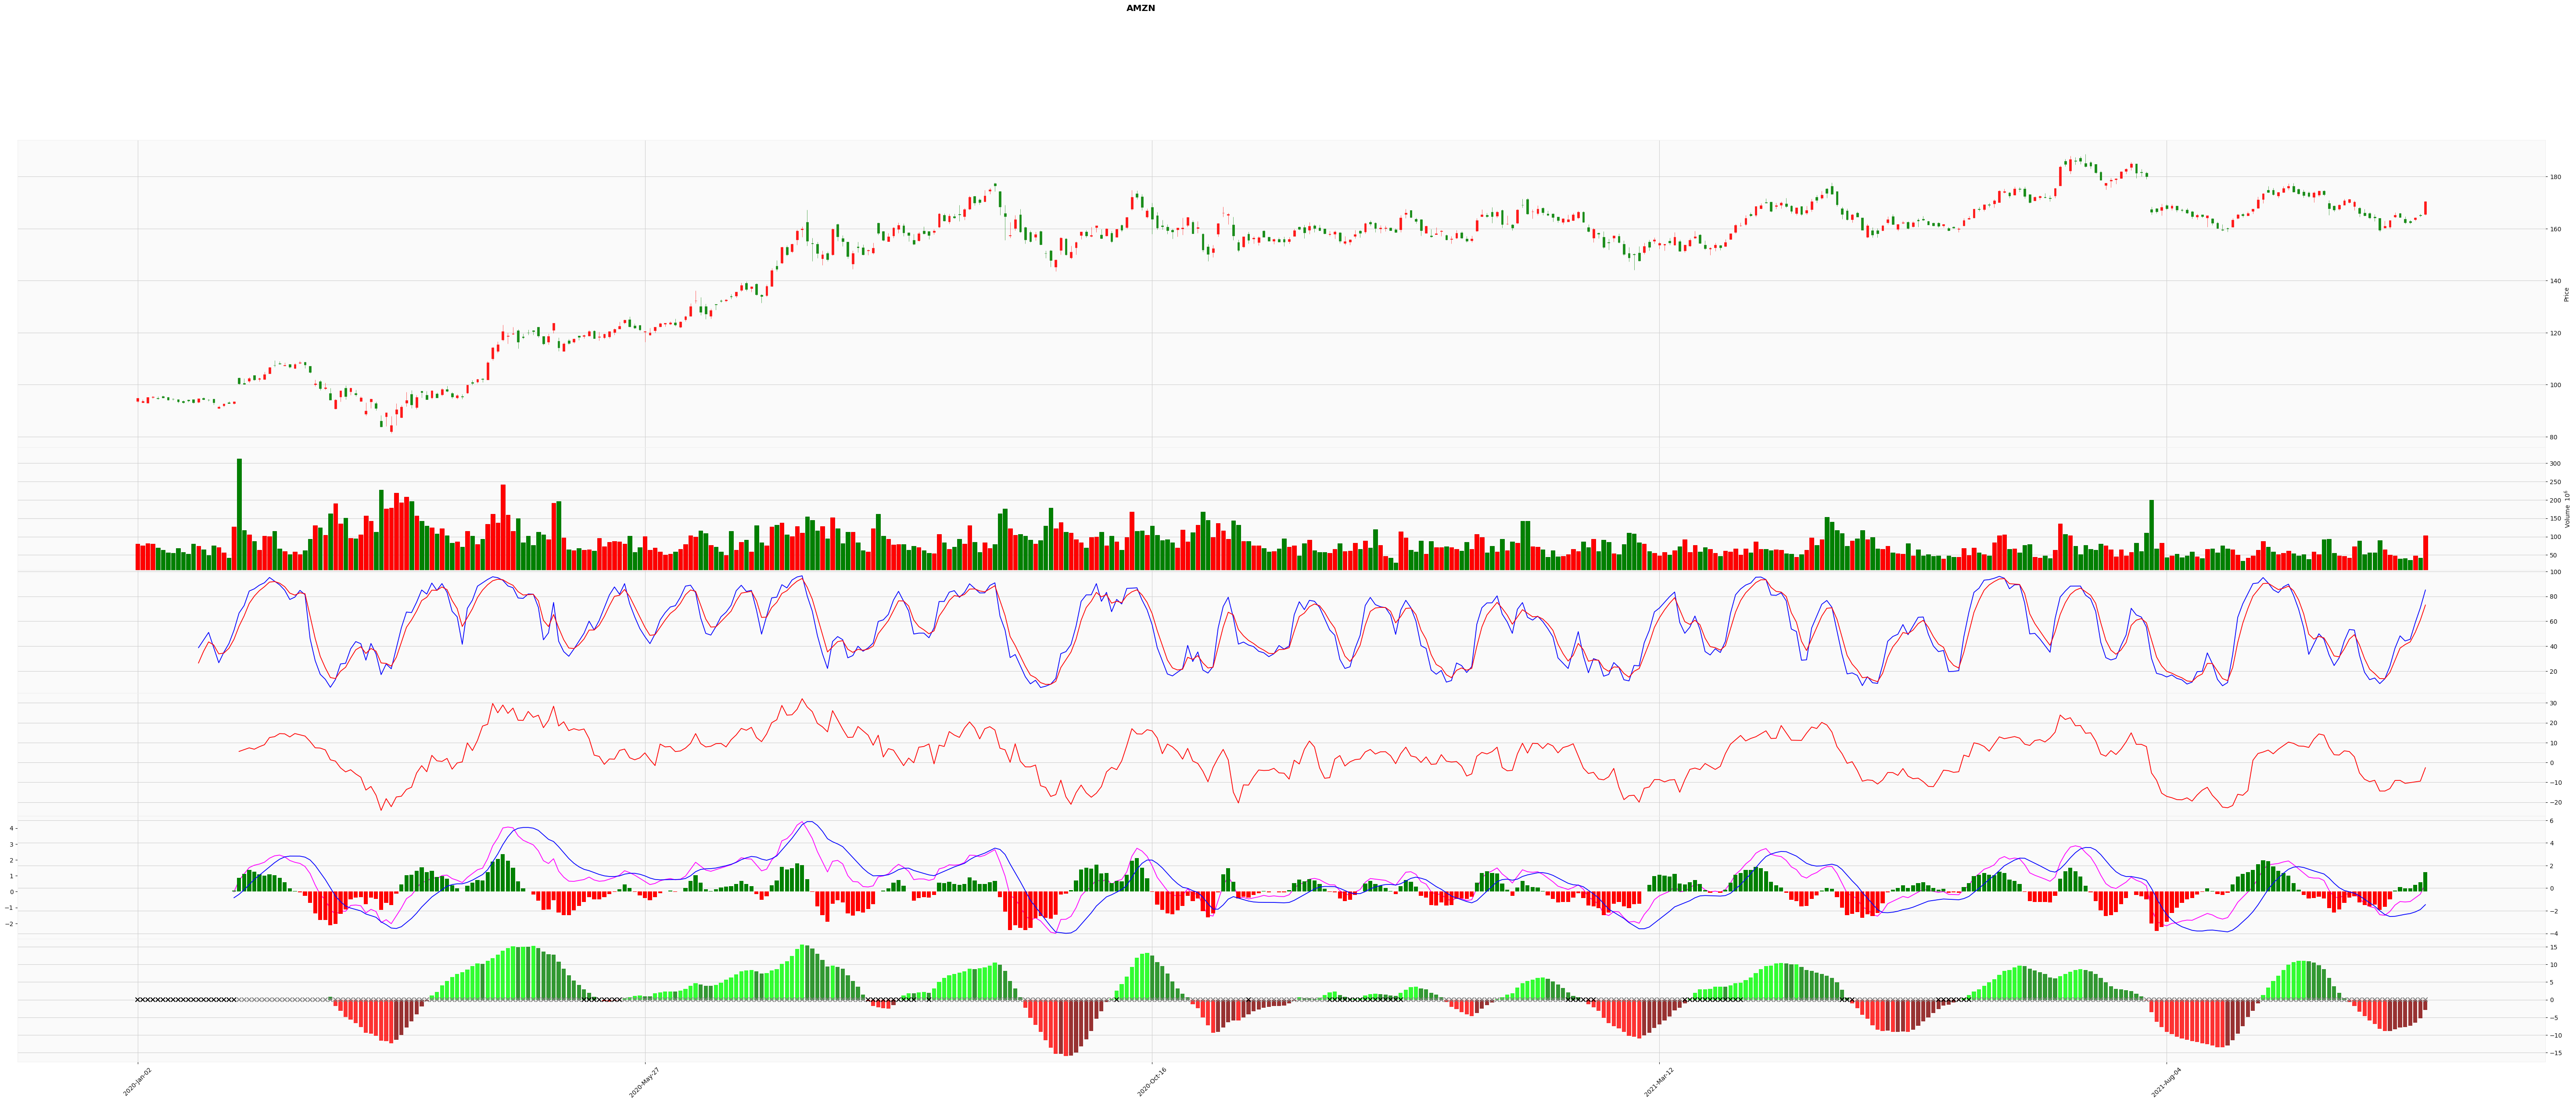

In [5]:
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
add_plot =[ 
            mpf.make_addplot(technical_indicator(ticker)["k"],panel= 2,color="b"),
            mpf.make_addplot(technical_indicator(ticker)["d"],panel= 2,color="r"),
            mpf.make_addplot(technical_indicator(ticker)["MOM"],panel= 3,color="r"),
            mpf.make_addplot(technical_indicator(ticker)["MACD"], panel=4, color='fuchsia'),
            mpf.make_addplot(technical_indicator(ticker)["MACDhist"], type='bar', panel=4, color=technical_indicator(ticker)['MACD_colors'].values),
            mpf.make_addplot(technical_indicator(ticker)["MACDsignal"], panel=4, color='b'),
            mpf.make_addplot(technical_indicator(ticker)['value'], panel=5, type='bar', color=technical_indicator(ticker)['Squeeze_colors'].values, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(technical_indicator(ticker)), panel=5, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in technical_indicator(ticker)['squeeze_off']], secondary_y=False)]
kwargs = dict(type='candle', volume = True,figsize=(80, 30),title = ticker, style=s,addplot=add_plot)
mpf.plot(technical_indicator(ticker), **kwargs)

In [6]:
class strategy_investment(Strategy): 
       
    def init(self):
        self.ema_short = self.I(talib.EMA, self.data.Close, 12) 
        self.ema_long = self.I(talib.EMA, self.data.Close, 26)
        self.macd =  self.ema_short - self.ema_long
        self.ema_signal = self.I(talib.EMA, self.macd, 9)
        self.mom = self.I(talib.MOM, self.data.Close, 10)

    def next(self):
        if (self.macd > self.ema_signal) and (self.mom > 0) and (self.data.squeeze_off[-2] == False) and (self.data.squeeze_off[-1] == True) and (self.data.value[-1] > 0) and (not self.position.is_long):
            self.buy()
        elif (self.macd < self.ema_signal) and (self.mom < 0) and (self.data.squeeze_off[-2] == False) and (self.data.squeeze_off[-1] == True) and (self.data.value[-1] > 0):
            self.position.close()

In [7]:
bt = Backtest(technical_indicator(ticker), strategy_investment, cash=10000, commission=0.002)
stats = bt.run()
bt.plot()

[*********************100%***********************]  1 of 1 completed


C:\Users\ju810609\AppData\Roaming\Python\Python39\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\ju810609\AppData\Roaming\Python\Python39\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1914', ...)

In [8]:
stats

Start                     2020-01-02 00:00:00
End                       2021-10-15 00:00:00
Duration                    652 days 00:00:00
Exposure Time [%]                   56.858407
Equity Final [$]                 10294.499947
Equity Peak [$]                  11596.468728
Return [%]                           2.944999
Buy & Hold Return [%]               79.610232
Return (Ann.) [%]                    1.631353
Volatility (Ann.) [%]               19.848472
Sharpe Ratio                          0.08219
Sortino Ratio                        0.117325
Calmar Ratio                          0.11225
Max. Drawdown [%]                  -14.533268
Avg. Drawdown [%]                   -8.382921
Max. Drawdown Duration      197 days 00:00:00
Avg. Drawdown Duration       72 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       2.953594
Worst Trade [%]                      2.953594
Avg. Trade [%]                    